# Проект: А/В тестирование

## Описание проекта:
<a name='project'></a>

**Вводные данные:** вместе с отделом маркетинга интернет магазина (выдуманный) подготовлен список гипотез для увеличения выручки.\
**Задача:** приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.\
**Цель:** увеличить выручку интернет-магазина, базируясь на данных, полученных на основе проведённых А/В-тестов.

Весь проект состоит из двух частей:\
**Часть 1. приоритезация гипотез:**\
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach, Impact, Confidence, Effort`.\
**Задача:**
1. Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
2. Применить фреймворк RICE для приоритизации гипотез. Отсортируйть их по убыванию приоритета.
3. Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.
4. Объяснить, почему так произошло.

**Часть 2. Анализ A/B-теста:**\
Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.\
**Задача:**
1. Проанализируйть A/B-тест.
2. Принять решение по результатам теста и объяснить его.\

Варианты решений:
* Остановить тест, зафиксировать победу одной из групп.
* Остановить тест, зафиксировать отсутствие различий между группами.
* Продолжить тест.

## Содержание проекта:
<a name='summ'></a>
1. [Описание проекта](#project)
2. [Содержание проекта](#summ)
3. [Часть 1. Приоритезация гипотез](#prior)
 * 1.[Выгрузка библиотек и данных, очистка данных](#df)
 * 2.[Применение фреймворка ICE](ice)
 * 3.[Применение фреймворка RICE](#rice)
 * 4.[Вывод](#conclusion1)
4. [Часть 2. Анализ A/B-теста](#AB) 
 * 1.[Проверка рабиения пользователей на группы](#set)
 * 2.[Создание единой таблицы](#table)
 * 3.[График кумулятивной выручки по группам](#v)
 * 4.[График кумулятивного среднего чека по группам](#bills)
 * 5.[График относительного изменения кумулятивного среднего чека группы B к группе A](#billsall)
 * 6.[График кумулятивного среднего количества заказов на посетителя по группам](#orders)
 * 7.[Точечный график количества заказов по пользователям](#dote)
 * 8.[95-й и 99-й перцентили количества заказов. Выбор границы для определения аномальных заказов](#proc)
 * 9.[Точечный график стоимостей заказов, 95-й и 99-й перцентили стоимости заказов](#st)
 * 10.[Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#stat)
 * 11.[Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#avgb)
 * 12.[Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#clean)
 * 13.[Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#chek)
 * 14.[Конечный вывод](#end)
5. [Итог тестирования](#theend)

## Часть 1. Приоритезация гипотез
<a name='prior'></a>

### Выгрузка библиотек и данных, очистка данных
<a name='df'></a>

In [1]:
#Окно под загрузку нужных в работе библиотек:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.dates as mdates

In [2]:
#Выгрузим данные из файлов CSV:
df = pd.read_csv('/datasets/hypothesis.csv')
pd.options.display.max_colwidth = 110 #иначе не видно полного названия гипотезы в столбце Hypothesis
#посмотрим на данные:
display(df)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Всего мы видим 9 гипотез, в нумерации, начиная с 0. Для каждой из гипотезы проведена оценка методик, которые используются во время применения фреймворков.\
Для дальнейшего нашего удобства, приведём названия столбцов к нижнему регистру.

In [3]:
df.columns = df.columns.str.lower()

Каких-то ошибок в данных (именно табличных, попавших случайно или не верно внесённых), на первый взгляд - нет. 

In [4]:
#Выгрузим таблицу заказов
orders = pd.read_csv('/datasets/orders.csv')
display(orders.sample(5))
orders.info()

,transactionId,visitorId,date,revenue,group
132,665271848,3873846164,2019-08-22,6922,B
316,4226817726,1349865791,2019-08-19,2490,A
445,2656017279,2288159513,2019-08-03,390,A
878,3315359627,1831956319,2019-08-05,90,A
1187,2274188238,132143192,2019-08-14,750,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
#столбец с датой нужно привести к нормальному формату:
orders['date'] = pd.to_datetime(orders['date'])

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
display(visitors.sample(5))
visitors.info()

,date,group,visitors
47,2019-08-17,B,421
29,2019-08-30,A,490
30,2019-08-31,A,699
10,2019-08-11,A,718
36,2019-08-06,B,655


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [7]:
#Здесь тоже нужно столбец с датой привести к нормальному формату
visitors['date'] = pd.to_datetime(visitors['date'])

Названия столбцов имеют нормальный вид, редактировать не будем.\
Посмотрим, нет ли в данных дубликатов:

In [8]:
duplicateRows = df[df.duplicated()]
duplicateRows

,hypothesis,reach,impact,confidence,efforts


In [9]:
duplicateRows = orders[orders.duplicated()]
duplicateRows

,transactionId,visitorId,date,revenue,group


In [10]:
duplicateRows = visitors[visitors.duplicated()]
duplicateRows

,date,group,visitors


Очевидных дубликатов в данных нет.\
**Так как первичный обзор данных не выявил критических ошибок, переходим к оценке гипотез**

### Применение фреймворка `ICE`
<a name='ice'></a>

**ICE** (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач.\
`ICE = impact * confidence * ease
ICE = (impact * confidence)/efforts`
* impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
* Efforts — сколько стоит протестировать эту гипотезу;

In [11]:
df.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [12]:
#посчитаем ICE и добавим его как новый столбец:
df['ICE'] = df['impact'] * df['confidence']/df['efforts']

df['ICE'] = df['ICE'].astype('float')

ice = df[['hypothesis','ICE']]

display(df[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


По данным `ICE` наиболее перспективными гипотезами будут являться (8,0,7):\
1. Запустить акцию, дающую скидку на товар в день рождения - **ЛИДИРУЕТ**;
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
3. Добавить форму подписки на все основные баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию. 

Самыми не перспективными будут гипотезы под номерами: 5,3,4.\
Гипотезы под номерами: 6, 2, 1 - так же не самые песпективные, исходя из полученного показателя

### Применение фреймворка `RICE`
<a name='rice'></a>

`RICE` = (Reach * Impact * Confidence)/ Efforts\
Указанный здесь фреймворк так же популярен как и ICE, в свою очередь ICE является модификацией RICE.\
Фреймворк RICE состоит из четырёх компонент:
* Reach — скольких пользователей затронет изменение, которое вы хотите внести;
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
* Efforts — сколько стоит протестировать эту гипотезу. 

In [13]:
df['RICE'] = (df['reach']*df['impact']*df['confidence'])/df['efforts']

rice = df[['hypothesis', 'RICE']]

display(df[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Лидирующей гипотизой является - 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.\
Отстают: 2,0,6.\
Гипотеза,которая была наиболее успешной по данным ICE здесь заняла только 5 место.\
В RICE учитывается, как много пользователей затронет принятая гипотеза. Анализ проводится для огромного интернет-магазина, соответственно, количество пользователей в нём большое. Возможно, стоит учитывать именно фреймворк RICE и отвергнуть то, что мы получили в ICE, так как ICE количество пользователей не учитывает.  

**Вывод:**
<a name='conclusion1'></a>
1. При применении фреймворка `ICE` лидирующей гипотезой является - 8 (Запустить акцию, дающую скидку на товар в день рождения).
2. При применении фреймворка `RICE` лидирующей гипотезой является - 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок).
3. При применении гипотизы ICE, гипотеза №7 занимает - 3 место. 
4. При применении гипотезы RICE, гипотеза №8 занимает - 5 место. 
5. Основываясь на том, что наш интернет магазин - огромный и популярный, учитывая важность количества пользователей - изменилась и приотритезация гипотез в этих двух фреймворках, так как ICE не учитывает число пользователей, а RICE учитывает и их количетсво сильно влияет на фреймворк. От сюда различия в ICE и RICE. 

#### Объединённая таблица по двум фреймворкам:

In [14]:
merged_df = pd.merge(ice, rice, on='hypothesis')
merged_df['number'] = np.arange(len(merged_df))

In [15]:
df_styled = merged_df.style.background_gradient(cmap='Greens')
df_styled

,hypothesis,ICE,RICE,number
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000,0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000,2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000,5
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000,6
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000,7
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000,8


In [16]:
#сделаем диаграмму слоупграф:
slopegraph_df = merged_df[['ICE', 'RICE', 'number']].copy()

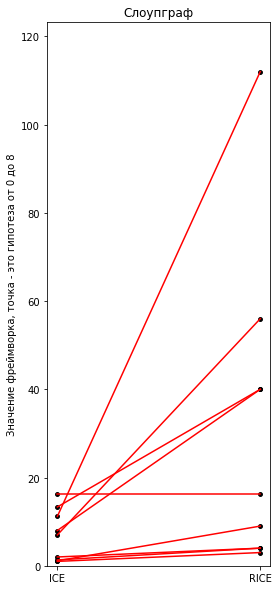

In [17]:
fig, ax = plt.subplots(figsize=(4, 10))

# Plot the lines connecting the dots and add labels for each hypothesis
for name, group in slopegraph_df.groupby('number'):
    ice = group['ICE'].values
    rice = group['RICE'].values

    # Plot the lines connecting the dots
    ax.plot([0, 1], [ice, rice], c='red')

    # Plot the points
    ax.scatter([0] * len(ice), ice, c='k', s=15, label='ICE')
    ax.scatter([1] * len(rice), rice, c='k', s=15, label='RICE')

    # Add the name of the hypothesis
    #ax.annotate(name, (-0.05, (ice[-1] + rice[-1]) / 2), ha='right', va='center')

# Set the x-axis ticks and labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['ICE', 'RICE'])

# Set the y-axis labels and limits
ax.set_ylabel('Значение фреймворка, точка - это гипотеза от 0 до 8')
ax.set_ylim([0, max(slopegraph_df[['ICE', 'RICE']].values.flatten()) * 1.1])  # Adjust the limit if needed

# Add title and legend
ax.set_title('Слоупграф')
#ax.legend()

plt.show()

На графике выше показана как менялась приоритезация гипотез. Слева фреймворк ICE от 0 до 8 гипотизы. Справа RICE. Они соединены попарно для удобства отслеживания приоритезации. 

## Часть 2. Анализ A/B-теста
<a name='AB'></a>

### Проверка разбиения пользователей на группы
<a name='set'></a>

Сначала проверим, нет ли пользователей, которые попали как в группу А так и в группу В и , если такие найдутся - нужно оценить их количество, а так же их нужно удалить из анализа, так как они могут сильно повлиять на общую оценку всего теста.

In [18]:
orders[orders['group'] == 'A']['visitorId'].isin(orders[orders['group'] == 'B']['visitorId']).sum()

89

Как видим, оказывается, целых 89 человек есть как в группе А так и в В. По каким причинами они туда попали - мы точно не знаем, возможно, технический сбой или ошибка при заполнении таблицы. Может, была ошибка в настройке теста. 

In [19]:
wrong_users = pd.Series(list(set(orders[orders['group'] == 'A']['visitorId'])\
                             .intersection(set(orders[orders['group'] == 'B']['visitorId']))))
orders = orders.loc[~orders['visitorId'].isin(list(wrong_users))]

Почистили наши данные от 89 человек.

### Создание единой таблицы
<a name='table'></a>

Для проведения данного теста необходимо объединить таблицы с заказами, посетителями интернет-магазина. 

In [20]:
display(orders.head(3))
display(visitors.head(3))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [21]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
pd.set_option('display.max_rows', None)
display(cumulativeData)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
5,2019-08-03,B,54,53,288850,1803
6,2019-08-04,A,77,71,388030,2562
7,2019-08-04,B,68,66,385740,2573
8,2019-08-05,A,99,92,474413,3318
9,2019-08-05,B,89,87,475648,3280


Исселедование длилось в течение месяца. 

### График кумулятивной выручки по группам
<a name='v'></a>

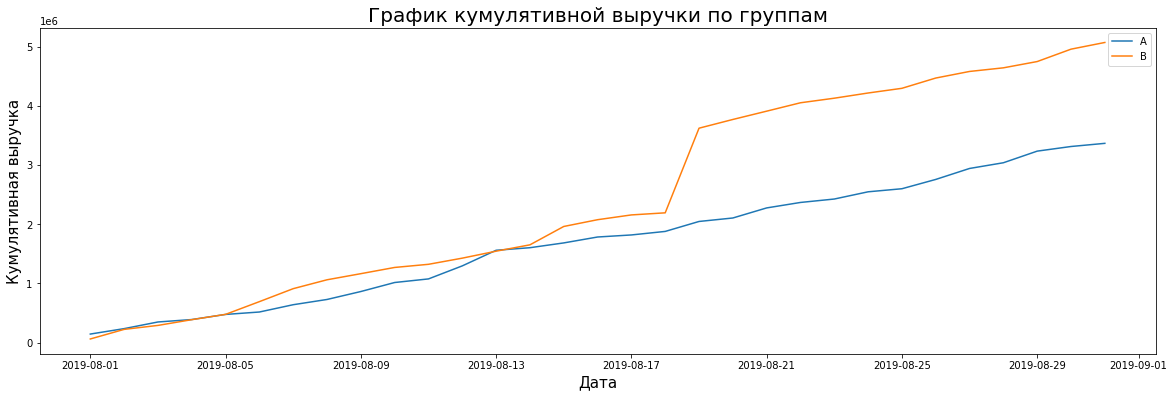

In [22]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title("График кумулятивной выручки по группам", fontsize=20)
plt.xlabel("Дата", fontsize=15)
plt.ylabel("Кумулятивная выручка", fontsize=15)
plt.legend();

Мы видим, что после 17 августа сегмент В резко поднимается по кумулятивной выручке. В самом начале тестирования (1 августа 2019 года) группы А и В шли вместе, после 5 августа группа В начала обгонять группу А, которая набирает выручку на протяжении всего тестирования стабильно. После 17 августа по непонятным причинам группа В резко вырвалась вперед. Вероятно, необходимо проверить данные в группе В на выбросы. 

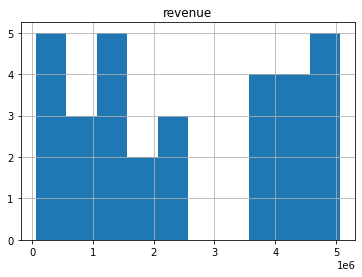

In [23]:
cumulativeData[cumulativeData['group'] == 'B'].hist('revenue');

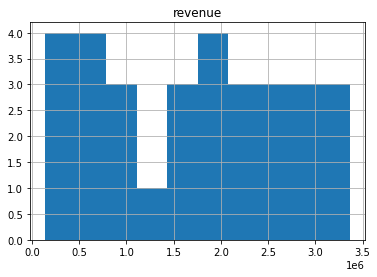

In [24]:
cumulativeData[cumulativeData['group'] == 'A'].hist('revenue');

В общих чертах не видно каких-то часто встречающихся выбросов ни в А ни в В группе, даже если поменять количество корзин у гистограммы. Видимо, в группе В и случилось сколько-то выбросов, но они в целом показывали лучшую динамику по количеству выручки, чем в группе А даже без происшествия с выручкой от 17 сентября. Что именно произошло трудно сказать, из таблицы видно, что в группе В было больше и посетителей и трат в сутки. Возможно, после 17 сентября в целом стало больше посетителей и накопленная выручка резко подскочила. 

### График кумулятивного среднего чека по группам
<a name='bills'></a>

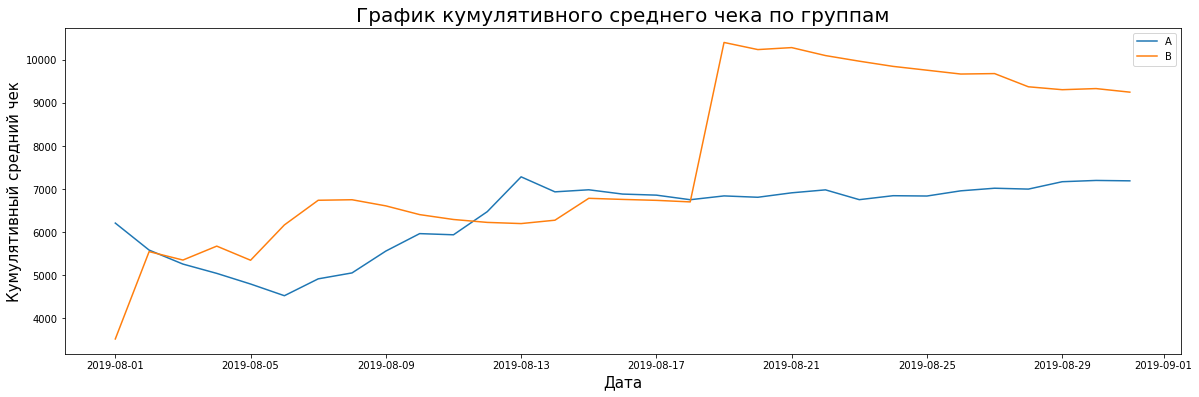

In [25]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]
plt.figure(figsize=(20, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title("График кумулятивного среднего чека по группам", fontsize=20)
plt.xlabel("Дата", fontsize=15)
plt.ylabel("Кумулятивный средний чек", fontsize=15)
plt.legend();

Действительно, после 17 августа резко вырос средний чек в группе В. В группе А к 17 августа средний чек вышел на плато. В группе же В он сначала резко вырос (после 17 августа), а затем стал медленно снижаться. Всё же, вероятно, около 19 августа был какой-то нестандартный заказ на большую сумму. Поэтому дальше средний чек в группе В падает, подобных крупных заказов не повторяется и накопленная сумма по чекам снижается. 

### График относительного изменения кумулятивного среднего чека группы B к группе A
<a name='billsall'></a>

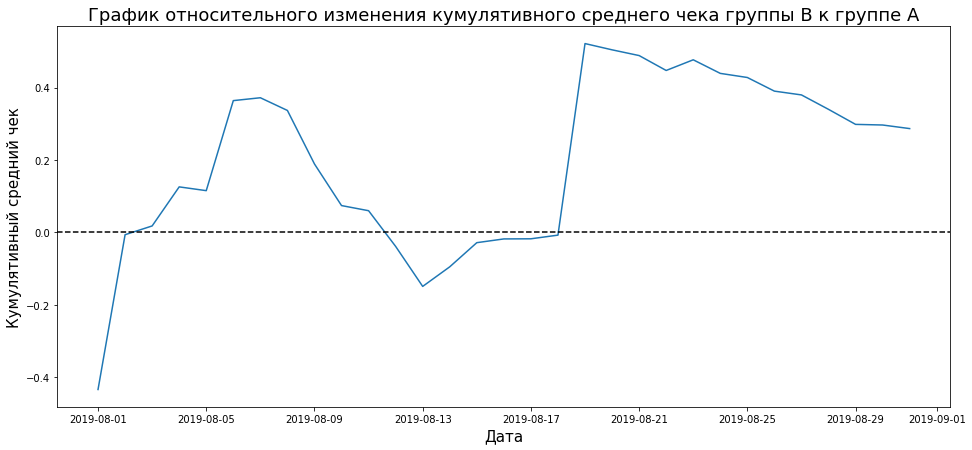

In [26]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16, 7))

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A", fontsize=18)
plt.xlabel("Дата", fontsize=15)
plt.ylabel("Кумулятивный средний чек", fontsize=15)


# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');


Результаты теста резко меняются около 9 августа и, как раз, нашего яркого 19 августа (после 17). Очевидно, что в эти даты совершались какие-то аномальные покупки. 

### График кумулятивного среднего количества заказов на посетителя по группам. 
<a name='orders'></a>

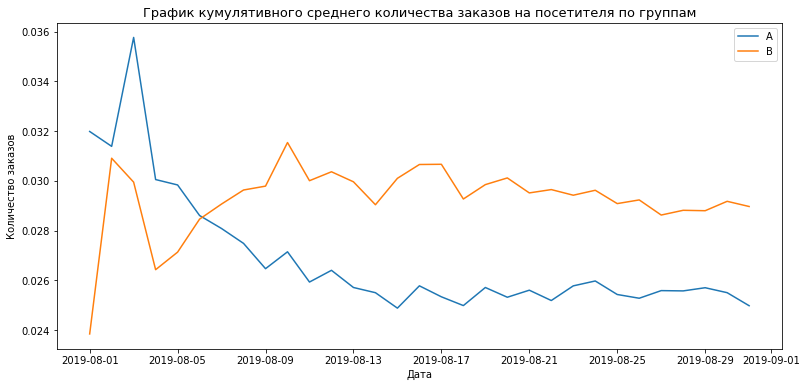

In [27]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']



# отделяем данные по группе A

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']



# отделяем данные по группе B

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']



# строим графики

plt.figure(figsize=(13, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')

plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title("График кумулятивного среднего количества заказов на посетителя по группам", fontsize=13)
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend();


По сути - это конверсия (просто посетители сайта, перешедшие в покупателей). В самом начале покупок - конверсия была больше у группы А, но она стабильно снижалась на протяжении всего тестирования. После 5 августа конверсия группы В стала выше конверсии группы А. Мы видим и её постепенное снижение, но она стабильно выше конверсии группы А начиная с 6 августа.

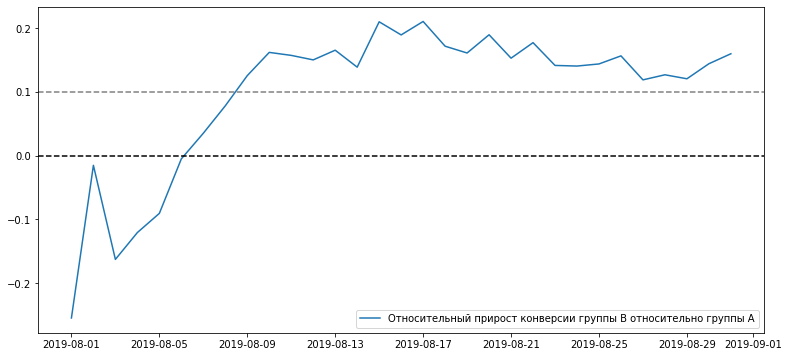

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


plt.figure(figsize=(13, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,  label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()



plt.axhline(y=0, color='black', linestyle='--')

plt.axhline(y=0.1, color='grey', linestyle='--');


Мы построили график относительного различия конверсии между группой А и группой В. Почти с самого начала теста, сразу после 5 августа, конверсия группы В становится лучше и лучше. Она зафиксировалась около прироста в 10% относительно группы А в последней трети теста.

### Точечный график количества заказов по пользователям
<a name='dote'></a>

Создадим таблицу с заказами и уникальным ID пользователей.

In [29]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

ordersByUsers.columns = ['userId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


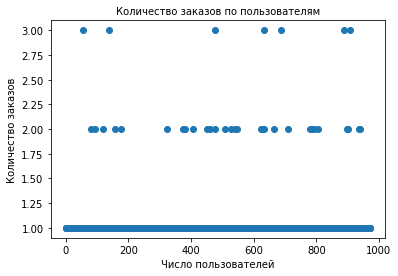

In [30]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title("Количество заказов по пользователям", fontsize=10)
plt.xlabel("Число пользователей")
plt.ylabel("Количество заказов");

По точечной диаграмме видно, что пользователей, которые сделали более 1 заказа не так уж много, вероятно - это выбросы. Убедимся в этом посчитав перцентили.

###  95-й и 99-й перцентили количества заказов. Выбор границы для определения аномальных заказов
<a name='proc'></a>

In [31]:
percentile_orders = np.percentile(ordersByUsers['orders'], [90, 95, 99])
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 1. 2.]


Не больше 5% пользователей совершили более 1 заказа, не болеше 1% пользователей совершали больше 2 заказов. 

Исходя из полученных данных, границей определения аномальных заказов - выбираем 1 заказ. Если пользователь совершил 2 и более заказа - будем считать выбросом (аномальным заказом). 

### Точечный график стоимостей заказов, 95-й и 99-й перцентили стоимости заказов
<a name='st'></a>

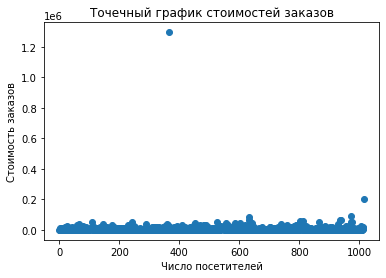

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.title("Точечный график стоимостей заказов", fontsize=12)
plt.ylabel("Стоимость заказов", fontsize=10)
plt.xlabel("Число посетителей")
plt.scatter(x_values, orders['revenue']);

In [33]:
percentile_revenue = np.percentile(orders['revenue'], [90, 95, 99])
percentile_revenue

array([17990., 26785., 53904.])

Не более 5% пользователей совершили покупок на сумму больше 26 785 рублей. И лишь 1% и меньше сделали покупку на суму 53 904 рубля. 

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным
<a name='stat'></a>

Статистическую значимость различий будем искать с помощью критерия Манна-Уитни, который может быть использован как для нормального распределения, так и для ненормально распределённых данных. Данный тест наиболее показателен и менее чувствителен к выбросам, так как в своей основе учитывает РАНГИ для данных в двух группах, а не их непосредственные значения. 

Создадим сводную таблицу для дальнейшей работы с данными.

In [34]:
#Разобъем пользователей на группу А и группу В
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
#Посчитаем куммуляцию пользователей группы А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
#Проделаем такие же шаги для группы В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
#Считаем куммуляцию для группы В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
#Посчитаем заказы группы А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
#Посчитаем куммуляцию заказов группы А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
#Проделаем аналогиченые шаги для группы В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]


In [35]:
#Создаем сводник
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

**Формулируем гипотизу:**\
Н0 - различий между средними у группы А и В нет.\
Н1 - различия есть.\
alpha = 0.05

In [36]:
#Считаем заказы группы А
ordersByUsersA = (

    orders[orders['group'] == 'A']

    .groupby('visitorId', as_index=False)

    .agg({'transactionId': pd.Series.nunique})

)

ordersByUsersA.columns = ['userId', 'orders']
#Группы В
ordersByUsersB = (

    orders[orders['group'] == 'B']

    .groupby('visitorId', as_index=False)

    .agg({'transactionId': pd.Series.nunique})

)

ordersByUsersB.columns = ['userId', 'orders']
#Делаем выборку пользователей по группе А
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)


#Создаем выборку пользователей по группе В
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("Уровень значимости р = ", "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]), 'для сравнения среднего между группами А и В')

print("Относительное различие в среднем между группами = ", "{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

Уровень значимости р =  0.01102 для сравнения среднего между группами А и В
Относительное различие в среднем между группами =  0.160


**Вывод:** Гипотезу Н0-отвергаем (Различий между средними у групп нет) так как р < 0.05 (p-value=0.01). Принимаем Н1 - различия между группами (по среднему количеству заказов) есть. Относительный прирост среднего группы В к конверсии группы А = 16 %.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным
<a name='avgb'></a>

In [37]:
print("Уровень значимости р = ",'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print("Относительное различие среднего чека между группами = ",'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Уровень значимости р =  0.829
Относительное различие среднего чека между группами =  0.287


Уровень значимости р > 0.05 (p-value = 0.8), следовательно, отвергнуть Н0 нельзя (Различий в среднем чеке нет). Следовательно,относительное различие среднего чека между группами А и В , равное 28.7% не является статистически значимым. \
Переходим к обработке выбросов и очистке "сырых" данных. 

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным
<a name='clean'></a>

Приступаем к подготовке очищенных от аномалий данных. 

Напомним, *что 95-й и 99-й перцентили средних чеков равны* **26 785 и 53 904** рублям. *А 95-й и 99-й перцентили числа заказов на одного пользователя равны* **1 и 2** заказа на пользователя. 
Примем за аномальных пользователей тех, кто совершил **2** заказа и более, или совершил заказ на сумму свыше **27 000** рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% заказов с наибольшей стоимостью.\
Удалять нужно именно пользователей — сначала определить аномальные заказы. Затем пользователей, совершивших их, и добавить их в список аномальных.\
            Сделаем срезы пользователей с числом заказов больше 1 — `usersWithManyOrders` и пользователей, совершивших заказы дороже 27 000 — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`, удалим дубликаты, отсортируем по возрастанию. 

In [38]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)


ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)


In [39]:
usersWithManyOrders = pd.concat(

    [

        ordersByUsersA[ordersByUsersA['transactionId'] > 1]['visitorId'],

        ordersByUsersB[ordersByUsersB['transactionId'] > 1]['visitorId'],

    ],

    axis=0,

)

usersWithExpensiveOrders = orders[orders['revenue'] > 27000]['visitorId']

abnormalUsers = (

    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)

    .drop_duplicates()

    .sort_values()

)

display(abnormalUsers.head(5))
display(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64

86

Количество посетителей, которые сделали аномальные заказы (больше 1 заказа на сумму больше 27 000 рублей) равняется 83 людям. Удалим аномальных пользователей. Создадим переменные `sampleAFiltered ` и `sampleBFiltered`, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей. 

**Формулируем гипотезу:**\
H0 - среднее в группах А и В равно.\
Н1 - среднее не равно.\
alpha = 0.05

In [40]:
sampleAFiltered = pd.concat(

    [

        ordersByUsersA[

            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))

        ]['transactionId'],

        pd.Series(

            0,

            index=np.arange(

                data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])

            ),

            name='orders',

        ),

    ],

    axis=0,

)



sampleBFiltered = pd.concat(

    [

        ordersByUsersB[

            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))

        ]['transactionId'],

        pd.Series(

            0,

            index=np.arange(

                data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])

            ),

            name='transactionId',

        ),

    ],

    axis=0,

)





print("Уровень значимости р для сравнения среднего между очищенными группами = ", '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Относительный прирост среднего очищенной группы B,', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Уровень значимости р для сравнения среднего между очищенными группами =  0.01593
Относительный прирост среднего очищенной группы B, 0.174


**Вывод**: По очищенным данным уровень значимости р < 0.05 (p-value=0.02), следовательно, мы отвергаем Н0 - что среднее в группе равно, и принимаем альтернативную гипотезу Н1, о том, что конверсия в группе В выше, чем в группе А, причём в группе В конверсия выше на 17.4%. Сегмент В значительно лучше сегмента А. 

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным
<a name='chek'></a>

In [41]:
print('p-value для сравнения средних чеков между очищенными группами = ',

    '{0:.3f}'.format(

        stats.mannwhitneyu(

            orders[

                np.logical_and(

                    orders['group'] == 'A',

                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),

                )

            ]['revenue'],

            orders[

                np.logical_and(

                    orders['group'] == 'B',

                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),

                )

            ]['revenue'],

        )[1]

    )

)



print('Относительный прирост среднего чека очищенной группы B,',

    "{0:.3f}".format(

        orders[

            np.logical_and(

                orders['group'] == 'B',

                np.logical_not(orders['visitorId'].isin(abnormalUsers)),

            )

        ]['revenue'].mean()

        / orders[

            np.logical_and(

                orders['group'] == 'A',

                np.logical_not(orders['visitorId'].isin(abnormalUsers)),

            )

        ]['revenue'].mean()

        - 1

    )

)

p-value для сравнения средних чеков между очищенными группами =  0.727
Относительный прирост среднего чека очищенной группы B, -0.034


Уровень значимости р > 0,05 (p-value=0.7). Отвергнуть нулевую гипотезу нельзя. Разницы между средними чеками нет. Относительное снижение среднего чека в группе В по сравнению с группой А в 3% не является статистически значимым. 

### Конечный вывод:
<a name='end'></a>

Подведём итог:
1.  Почти с самого начала теста - конверсия в группе В лучше. Она зафиксировалась около прироста в 10% относительно группы А.
2. Различия по конверсии между группами (по среднему количеству заказов) есть. Относительный прирост среднего группы В к конверсии группы А = 16% (p-value=0.01). - сырые данные
3. Различий в среднем чеке между А и В - нет. - сырые данные
4. Конверсия в группе В выше, чем в группе А, причём в группе В конверсия выше на 17,4% (p-value=0.02). Сегмент В значительно лучше сегмента А. - очищенные данные
5. Разницы между средними чеками нет. - очищенные данные.
\\\
\
Основываясь на вышеописанных показателях, можно говорить о том, что тестирование может быть остановлено. Группа В показывает себя лучше, хотя разницы в средних чеках с группой А - нет, но конверсия в группе В - выше, что тоже важно, так как это - интернет магазин и мы заинтересованы в переходе пользователя из "смотрящего" в "покупающего". 

# Итог тестирования:
<a name='theend'></a>

Перед проведением А/В - тестирования, мы провели исследование двух фреймворков ICE и RICE и входящих в них 8 гипотез.\
Так как фреймворки показали разные лидирующие гипотезы, от одного из них мы отказались (отказались от ICE). Так как исследование проводится для крупного интернет магазина, для которого очень важен охват пользователей, а фреймворк ICE к этому не чувствителен, и , так как лидирующая гипотиза из RICE все равно вошла в тройку лидеров ICE, то основным фреймворком мы решили считать RICE.\
По итогу исследования, лидирующей гипотезой оказалась нижеследующая:\
**Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**.\



После чего, мы начали А/В тестирование. 
В общей сложности, мы проводили его 1 месяц, оказалось, что конверсия пользователей в группе В была на 17,4 % выше (p-value = 0.02), чем в группе А. Хотя разницы в среднем чеке не было (p-value > 0.05). В среднем, конверсия к концу периода изучения стабильно была выше на 10% в группе В. На основании статистических расчётов, визуального изучения графиков - мы приняли решение тестирование - остановить.\
Победителем является группа В.

Так же, мы хотим отметить то, что типичным для пользователей является: **совершить 1 покупку на сумму ниже 27 000 рублей**. В 5 % случаев совершается 2 покупки, при этом от 27 000 до 54 000 рублей, в 1% случаев более 2 покупок по цене выше 54 000 рублей. 

После очистки данных в общей сложности было удалено 175 пользователей. Это были пользователи либо попавшие в 2 группы при тестировании (и в А и в В - 89 человек) либо пользователи, которые совершали аномальные покупки (не типичные для нашей выборки - 86 человек). 